In [1]:
import sys, getopt
import pandas as pd
import numpy as np
import os
import Tkinter, tkFileDialog

对于digi的数据，他们还会卖reward，例如价值50的东西，卖你19块。

### Read Data

In [2]:
inputfile = '/Users/ito/Downloads/AppAprMonthlyRewards.csv'
# inputfile = '/Users/vidyut/projects/digi/yiteng_code/180625/AppAprMonthlyRewards.csv'

In [3]:
details = pd.read_csv(inputfile, sep=',', engine='c') # , parse_dates=['TimeStamp']
print details.shape

(224, 29)


In [4]:
details.head(2)

,#,Category,Number of Outlet,Remarks,Group Name/Voucher Name,Length,Merchant Name (Tag),Redemption Type (Tag),Category.1,Voucher Type,...,Description in Goods,Terms and Conditions in Goods,internal url,CRM Offer Name (Prepaid),CRM Offer Name (Postpaid),CRM Offer ID (Postpaid),CRM Offer ID (Postpaid).1,In App Thumbnail,Unnamed: 27,Unnamed: 28
0,NaN,NaN,No of Outlets,NaN,Appear as the title of the rewards in Rewards ...,NaN,NaN,NaN,Category,NaN,...,This can be as descriptive as you want,standard T&C to be included,Do we don’t allow bringing user to external pa...,Applicable for Superdeals only.,Applicable for Superdeals only.,Applicable for Superdeals only.,Applicable for Superdeals only.,Key in Y if partner provide the thumbnail .,NaN,NaN
1,1.0,Monthly Rewards\n,1,Suria Sabah Mall Adoption\n*total updated not ...,Suria Sabah Shopping Mall: Free Digi Umbrella,45.0,Suria Sabah,offline,CAT=SHOPPING,generic promo code\n,...,MyDigi Reward:\nFree Digi umbrella when you sp...,Terms and Conditions:\nValid from now till 30 ...,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


* the first row is depicted with description for each feature/attribute
* hence cut the first one, and select some useful features to analyse

In [5]:
title = details.loc[[0]]
details = details[1:-1]
details = details[['Category','Number of Outlet','Remarks','Group Name/Voucher Name','Length','Merchant Name (Tag)','Redemption Type  (Tag)','Category.1','Voucher Type','Require daily cap?','Daily Cap Quantity','Require per user limit?','Per user limit Quantity','Total # of Codes','Campaign Start Date','Campaign End Date','Voucher Expiry Date','Promo Code','Description in Goods','Terms and Conditions in Goods']]

In [6]:
details.columns = ['Category','NoOutlet','Remarks','VoucherName','Length','MerchantName','RedemptionType','Category1',
          'VoucherType','RequireDailyCap','DailyCapQuantity','RequireUserLimit','UserLimitQuantity','NoCodes',
          'CampaignStartDate','CampaignEndDate','VoucherExpiryDate','PromoCode','Description','TermsConditions']

In [7]:
details.head(3)

,Category,NoOutlet,Remarks,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,RequireDailyCap,DailyCapQuantity,RequireUserLimit,UserLimitQuantity,NoCodes,CampaignStartDate,CampaignEndDate,VoucherExpiryDate,PromoCode,Description,TermsConditions
1,Monthly Rewards\n,1,Suria Sabah Mall Adoption\n*total updated not ...,Suria Sabah Shopping Mall: Free Digi Umbrella,45.0,Suria Sabah,offline,CAT=SHOPPING,generic promo code\n,No,Unlimited,Yes,1,"1,800",1/15/18 12:00 AM,6/30/18 11:59 PM,6/30/18 11:59 PM,SURIASABAHDIGI,MyDigi Reward:\nFree Digi umbrella when you sp...,Terms and Conditions:\nValid from now till 30 ...
2,Monthly Rewards\n,1,NaN,Gallery Korea Décor: RM50 cash voucher,38.0,Gallery Korea Décor\n,offline,CAT=SHOPPING,generic promo code\n,No,Unlimited,No,Unlimited,"9,999",1/15/18 12:00 AM,6/30/18 11:59 PM,6/30/18 11:59 PM,SURIASABAHDIGI,MyDigi Reward:\nGet RM50 cash voucher for purc...,Terms and Conditions:\nValid from now till 30 ...
3,Monthly Rewards\n,1,*various promo (goods + details vs tnc),Seven Optical: Buy 2 free 1,27.0,Seven Optical,offline,CAT=SHOPPING,generic promo code\n,No,Unlimited,No,Unlimited,"9,999",1/15/18 12:00 AM,6/30/18 11:59 PM,6/30/18 11:59 PM,SURIASABAHDIGI,MyDigi Reward:\nBuy 2 free 1 for color contact...,Terms and Conditions:\nValid from now till 30 ...


### Data Cleansing

* Exp-based Feature Selection

In [8]:
useful_features = ['Category','VoucherName','Length','MerchantName','RedemptionType','Category1',
          'VoucherType','NoCodes','Description','TermsConditions']

In [9]:
details = details[useful_features]

* Clean N.A. NaN

In [10]:
print details.shape
details = details.dropna(axis=0, thresh=10)  
print details.shape

(222, 10)
(163, 10)


In [11]:
# def digi_spec_split(input, sig = ': '):
#     sub_strs = input.split(sig)
#     if len(sub_strs)!=2:
#         sys.stdout.errors('new case...')
#     try:
#         return sub_strs[0], sub_strs[1]
#     except:
#         sys.stdout.errors('lesser than 2...')

* a preliminary process under NLP task -- transferring all the chars to lowercase

In [12]:
def lowercase(input):
    if type(input) == str:
        return input.decode('utf-8').lower()
    else:
        return input

In [13]:
details = details.replace(np.nan, 'None')
for each in details:
    details[each] = details[each].map(lowercase)

### Understanding the Voucher Name

* split by a colon (may need to modify in case the format changes)

In [14]:
def voucher_name_split(input):
    sub_strs = input.split(': ')
    if len(sub_strs)!=2:
        sys.stdout.errors('new case...')
    try:
        return sub_strs[0], sub_strs[1]
    except:
        sys.stdout.errors('lesser than 2...')
        
res_split = details.VoucherName.map(voucher_name_split)
details[['location', 'voucher']] = res_split.apply(lambda x: pd.Series([i for i in x]))

In [15]:
def category_split(input):
    sub_strs = input.split('cat=')
    if len(sub_strs)!=2:
        sys.stdout.errors('new case...')
    try:
        return sub_strs[1]
    except:
        sys.stdout.errors('unknown situation')
        
details['hierarchy'] = details.Category1.map(category_split)

* based on the content, generate a "keyword dict" to extract the type of reward

In [16]:
word_lst = [['buy','free'], ['buy','for the price'], '% discount','discount','free gift','free', 
            'cash voucher','gift voucher', '% off', 'off', 'complimentary', 'instant rebate', 'rebate'] 

# value_lst = [?, ?, per, real, ]
# word_lst2 = ['up to', 'extra', '']

In [17]:
def list_check(lst_ele, voucher):
    if lst_ele in voucher:
        return 0
    else:
        return 1

In [18]:
cat = []
for idx in range(details.shape[0]):
    each_voucher = details.iloc[idx].voucher
#     each_voucher = details.iloc[idx].voucher.split(' ')
    category = None
    for which, each in enumerate(word_lst):
        if type(each) == list:
            if sum([list_check(ele, each_voucher) for ele in each]) == 0:
                category = which
                break
        elif each in each_voucher:
            category = which
            break
    if (category == None) & ('rm' in each_voucher):
        # trick
        category = len(word_lst)
    
    cat.append(category)
    
details['voucher_cat'] = pd.Series(cat)

In [19]:
def categorize(each_voucher):
    for idx in range(details.shape[0]):
        category = None
        for which, each in enumerate(word_lst):
            if type(each) == list:
                if sum([list_check(ele, each_voucher) for ele in each]) == 0:
                    category = which
                    break
            elif each in each_voucher:
                category = which
                break
        if (category == None) & ('rm' in each_voucher):
            # trick
            category = len(word_lst)

        return category
details['voucher_cat'] = details.voucher.map(categorize)

In [20]:
details.head()

,Category,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,NoCodes,Description,TermsConditions,location,voucher,hierarchy,voucher_cat
1,monthly rewards\n,suria sabah shopping mall: free digi umbrella,45.0,suria sabah,offline,cat=shopping,generic promo code\n,"1,800",mydigi reward:\nfree digi umbrella when you sp...,terms and conditions:\nvalid from now till 30 ...,suria sabah shopping mall,free digi umbrella,shopping,5
2,monthly rewards\n,gallery korea décor: rm50 cash voucher,38.0,gallery korea décor\n,offline,cat=shopping,generic promo code\n,"9,999",mydigi reward:\nget rm50 cash voucher for purc...,terms and conditions:\nvalid from now till 30 ...,gallery korea décor,rm50 cash voucher,shopping,6
3,monthly rewards\n,seven optical: buy 2 free 1,27.0,seven optical,offline,cat=shopping,generic promo code\n,"9,999",mydigi reward:\nbuy 2 free 1 for color contact...,terms and conditions:\nvalid from now till 30 ...,seven optical,buy 2 free 1,shopping,0
4,monthly rewards\n,heatwave: 15% off,17.0,heatwave,offline,cat=shopping,generic promo code\n,"9,999",mydigi reward:\n15% discount on original price...,terms and conditions:\nvalid from now till 30 ...,heatwave,15% off,shopping,8
5,monthly rewards\n,52nd street saloon: 30% off on konxept product,46.0,52nd street saloon\n,offline,cat=beauty,generic promo code\n,"9,999",mydigi reward:\n30% off on konxept product,terms and conditions:\nvalid from now till 30 ...,52nd street saloon,30% off on konxept product,beauty,8


In [21]:
# each_voucher =  'rm6 hermo cash voucher'

# category = None
# for which, each in enumerate(word_lst):
#     if type(each) == list:
#         if sum([list_check(ele, each_voucher) for ele in each]) == 0:
#             category = which
#             break
#     elif each in each_voucher:
#         category = which
#         break
# if (category == None) & ('rm' in each_voucher):
#     # trick
#     category = len(word_lst)

# category

### Feature Eng

* For this, I will hence calculate a function that representing the voucher value (will do after NLP)

* details.RedemptionType.unique() -- array([u'offline', u'online'], dtype=object)
* details.VoucherType.unique() -- array([u'generic promo code\n', u'embedded promo code\n', u'unique promo code\n'], dtype=object)

In [22]:
RedemType_dic, VouchType_dic = dict(), dict()
RedemType_dic.update({'offline':0, 'online':1})
VouchType_dic.update({'generic promo code\n':1, 'embedded promo code\n':2, 'unique promo code\n':3})
details['RedemptionType'] = details.RedemptionType.map(RedemType_dic)
details['VoucherType'] = details.VoucherType.map(VouchType_dic)

* From number of codes, we can extract the value of the reward/voucher, using 1mil score as a base

查看一下这边 到底balance在哪里 会不会有bias

In [23]:
# details.Length.unique()
details.NoCodes.unique()

array([u'1,800', u'9,999', u'500,000', u'99,999', u'unlimited', u'2,000',
       u'3,000', u'10,000', u'1,000', u'3,001', u'30,000', u'200', u'100'], dtype=object)

In [24]:
NoCodes_dic = dict()
NoCodes_dic.update({'1,800':555.56, '9,999':100.01, '500,000':2.0, '99,999':10.0, 'unlimited':1.0, '2,000':500.0,
       '3,000':333.33, '10,000':100, '1,000':1000, '3,001':333.2, '30,000':33.33, '200':5000, '100':10000})
details['value'] = details.NoCodes.map(NoCodes_dic)

In [25]:
details.hierarchy.unique()

array([u'shopping', u'beauty', u'others', u'f&b', u'travel', u'digital'], dtype=object)

In [26]:
hierarchy_dic = dict()
hierarchy_dic.update({'shopping':1 , 'beauty':2 , 'others':3 , 'f&b':4 , 'travel':5 , 'digital':6})
details['hierarchy'] = details.hierarchy.map(hierarchy_dic)

In [27]:
details.head(2)

,Category,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,NoCodes,Description,TermsConditions,location,voucher,hierarchy,voucher_cat,value
1,monthly rewards\n,suria sabah shopping mall: free digi umbrella,45.0,suria sabah,0,cat=shopping,1,"1,800",mydigi reward:\nfree digi umbrella when you sp...,terms and conditions:\nvalid from now till 30 ...,suria sabah shopping mall,free digi umbrella,1,5,555.56
2,monthly rewards\n,gallery korea décor: rm50 cash voucher,38.0,gallery korea décor\n,0,cat=shopping,1,"9,999",mydigi reward:\nget rm50 cash voucher for purc...,terms and conditions:\nvalid from now till 30 ...,gallery korea décor,rm50 cash voucher,1,6,100.01


### Selection for clustering

* Category seems not usable in this case, as there is no diversity in this feature
* VoucherName is hence considered in the tf-idf model
* Length is just, the length of VoucherName...
* MerchantName is a double check feature for first seg of VoucherName
* NoCodes is hence translated to value
* voucher_cat is designed based on 
* hierarchy is categorized

In [28]:
clu_feas = ['RedemptionType', 'VoucherType', 'voucher_cat', 'value', 'hierarchy']
sub_details = details[clu_feas]

In [29]:
sub_details

,RedemptionType,VoucherType,voucher_cat,value,hierarchy
1,0,1,5,555.56,1
2,0,1,6,100.01,1
3,0,1,0,100.01,1
4,0,1,8,100.01,1
5,0,1,8,100.01,2
6,0,1,8,100.01,2
7,0,1,2,100.01,1
8,0,1,10,100.01,3
9,0,1,8,100.01,1
10,0,1,8,100.01,1


### Clustering side

In [30]:
from Clustering import Clustering

In [31]:
# assign 'cls' as the object of the class 'Clustering'
cls = Clustering()

In [32]:
cls.load_data(sub_details)

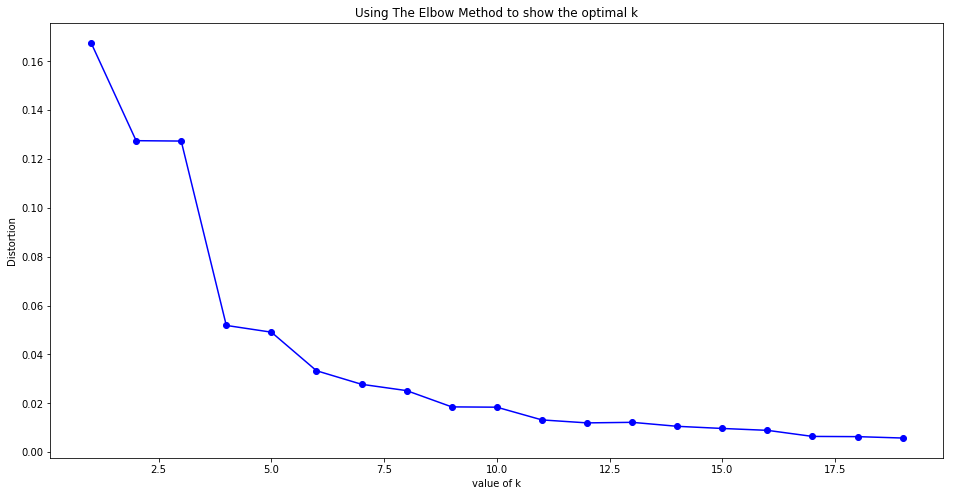

In [33]:
cls.elbow_w_kmeans()

* can see that k == 6

In [34]:
cls.clustering_method_1(k=6)

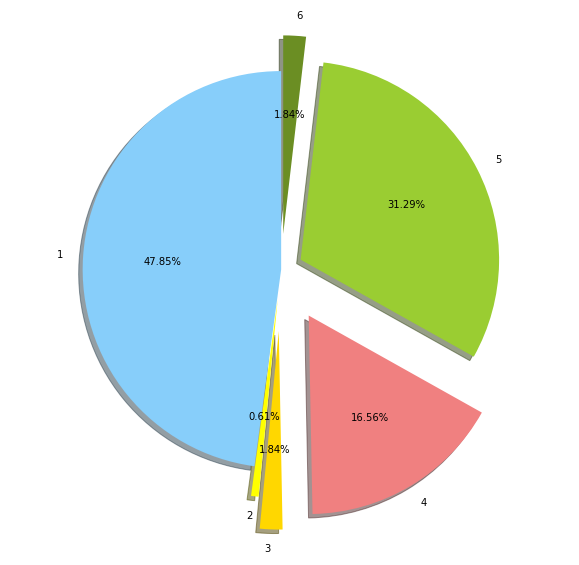

In [35]:
cls.return_piechart()

In [36]:
frame = cls.return_frame()

In [52]:
frame

,RedemptionType,VoucherType,voucher_cat,value,hierarchy,group
1,0,1,5,555.56,1,4
2,0,1,6,100.01,1,4
3,0,1,0,100.01,1,4
4,0,1,8,100.01,1,4
5,0,1,8,100.01,2,4
6,0,1,8,100.01,2,4
7,0,1,2,100.01,1,4
8,0,1,10,100.01,3,3
9,0,1,8,100.01,1,4
10,0,1,8,100.01,1,4


### Text Features Eng, for later tf-idf

In [37]:
def description_split(input):
    sub_strs = input.split(':\n')
    if len(sub_strs)!=2:
        sys.stdout.errors('new case...')
    try:
        return sub_strs[1]
    except:
        sys.stdout.errors('lesser than 2...')
        
details['desc'] = details.Description.map(description_split)

In [38]:
def description_split(input):
    if 'conditions:\n' in input:
        sub_strs = input.split('conditions:\n')
    elif 'details:\n' in input:
        sub_strs = input.split('details:\n')
        
    if len(sub_strs)!=2:
        print sub_strs
        sys.stdout.errors('new case...')
    try:
        return sub_strs[1]
    except:
        sys.stdout.errors('lesser than 2...')
details['tnc'] = details.TermsConditions.map(description_split)

In [39]:
details.head(2)

,Category,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,NoCodes,Description,TermsConditions,location,voucher,hierarchy,voucher_cat,value,desc,tnc
1,monthly rewards\n,suria sabah shopping mall: free digi umbrella,45.0,suria sabah,0,cat=shopping,1,"1,800",mydigi reward:\nfree digi umbrella when you sp...,terms and conditions:\nvalid from now till 30 ...,suria sabah shopping mall,free digi umbrella,1,5,555.56,free digi umbrella when you spend minimum rm20...,valid from now till 30 june 2018\nvalid at inf...
2,monthly rewards\n,gallery korea décor: rm50 cash voucher,38.0,gallery korea décor\n,0,cat=shopping,1,"9,999",mydigi reward:\nget rm50 cash voucher for purc...,terms and conditions:\nvalid from now till 30 ...,gallery korea décor,rm50 cash voucher,1,6,100.01,get rm50 cash voucher for purchase over rm500 ...,valid from now till 30 june 2018\nvalid at sho...


In [40]:
!pwd
# details.to_csv('to_vidyut.csv', encoding='utf-8')

/Users/ito/venv/pyspark-rec/code


### NLP task on "reward similarity consideration"

In [41]:
import sklearn

from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer  

In [42]:
details.head(10).desc.values

array([ u'free digi umbrella when you spend minimum rm200 in accumulated receipt with maximum 2 combined receipt',
       u'get rm50 cash voucher for purchase over rm500 and above in a single receipt (before 6% gst)',
       u'buy 2 free 1 for color contact lens and free eye test',
       u'15% discount on original priced item',
       u'30% off on konxept product',
       u'10% discount on hair coloring service',
       u'30% discount on disney new range including toiletries, bath and shampoo',
       u'complimentary phone answering for the first six (6) months',
       u'enjoy 10% off on normal priced items with every purchase of rm400 & above',
       u'get 20% off on normal price merchandise'], dtype=object)

### stop word consideration here

* This transfers words to a word-frequency matrix (initialization)
* Add analyzer, stop words and tokenization

In [43]:
# vectorizer=CountVectorizer()
vectorizer=CountVectorizer(analyzer='word', stop_words='english', token_pattern='\\b\\w+\\b')

* This counts the tf-idf weight for each word (initialization) 

In [44]:
transformer=TfidfTransformer()

* fit to our data

In [45]:
%%time
tfidf=transformer.fit_transform(vectorizer.fit_transform(details.desc.values))

CPU times: user 10.1 ms, sys: 4.35 ms, total: 14.5 ms
Wall time: 15.5 ms


* get all words from the bag of words model

In [46]:
word = vectorizer.get_feature_names()
for w in word:
    print w

1
10
12
12oz
15
2
20
25
3
30
30000mah
35
37
40
4r
5
50
50ml
50pcs
6
60
63
8
80
9
90
account
accumulated
additional
admission
advanced
aenon
air
ampoule
analysis
android
answering
app
apple
applicable
application
aquaria
art
asian
assortment
atelier
audio
authentic
award
awesome
axa
ayam
b
baguettes
baked
bank
bar
baskin
bath
bbq
beaute
belt
big
bindhu
bingsu
birthday
biryanies
bistro
black
blow
blue
body
book
booking
bow
bowl
bowls
boye
brabantia
brand
bread
breakfasts
brew
brightening
brownies
buffet
bun
burger
burgers
buy
c
cable
caf
cafe
cafes
cake
cakes
canadian
canvas
cap
capped
care
case
cash
cashback
cat
celeb
chance
cheek
chequers
chicken
chinese
choose
chuan
class
cleaning
coconut
coffee
coffees
cold
collagen
color
coloring
combined
combo
comfort
complimentary
contact
contemporary
cottage
couple
course
cream
creamy
creative
croutons
crunchy
cubes
cuisine
curry
customer
customized
data
day
deals
decadent
delhi
delicacies
delights
desserts
diamond
dieyalicious
digi
dine
dining
d

#### * extract tf-idf matrix, where the element a[i][j] represents the word_j's tf-idf-weight in text_i (each row)

In [47]:
# showcase
weight=tfidf.toarray()
for i in range(len(weight)):
    print "-------print out all tf-idf weights for text_" + str(i) + "-------"
    for j in range(len(word)):
        if weight[i][j]>0:
            print word[j],weight[i][j]  

-------print out all tf-idf weights for text_0-------
2 0.232324414907
accumulated 0.330792684273
combined 0.330792684273
digi 0.305985608973
free 0.147508464247
maximum 0.274732390237
minimum 0.193054654409
receipt 0.491953467226
rm200 0.305985608973
spend 0.232324414907
umbrella 0.330792684273
-------print out all tf-idf weights for text_1-------
6 0.376303188533
cash 0.354657481649
gst 0.406811098904
purchase 0.203052622124
receipt 0.302503864395
rm50 0.278542843601
rm500 0.406811098904
single 0.293641660907
voucher 0.324149571278
-------print out all tf-idf weights for text_2-------
1 0.200850569856
2 0.268384193506
buy 0.249840815938
color 0.38213602226
contact 0.38213602226
eye 0.38213602226
free 0.340807402685
lens 0.3534785654
test 0.38213602226
-------print out all tf-idf weights for text_3-------
15 0.455659876115
discount 0.325678927674
item 0.455659876115
original 0.54863918086
priced 0.421516832276
-------print out all tf-idf weights for text_4-------
30 0.44909592082
konx

sterilising 0.36739448069
treatment 0.273193751266
wax 0.36739448069
-------print out all tf-idf weights for text_50-------
1 0.344277004913
day 0.655017535211
free 0.292088172646
trial 0.605895924936
-------print out all tf-idf weights for text_51-------
50 0.56920883313
item 0.593298077338
selected 0.56920883313
-------print out all tf-idf weights for text_52-------
25 0.450112800221
brand 0.676567664133
selected 0.582798990156
-------print out all tf-idf weights for text_53-------
applicable 0.37376669383
items 0.249902298006
purchase 0.559677261384
receipt 0.277932115349
rm1 0.37376669383
rm150 0.32584940459
selected 0.297819587247
single 0.269789769905
-------print out all tf-idf weights for text_54-------
1 0.13366643022
10 0.153651376926
care 0.47048129393
customer 0.47048129393
discount 0.150962854832
existing 0.235240646965
free 0.113403982229
hair 0.422426567305
kit 0.235240646965
new 0.211213283652
package 0.235240646965
signing 0.235240646965
treatment 0.189106037201
------

20 0.27086169981
dining 0.514267681288
enjoy 0.209709309462
latest 0.555960743706
recipe 0.555960743706
-------print out all tf-idf weights for text_115-------
1 0.448670510778
buy 0.279053742741
edition 0.426817719303
enjoy 0.160996347664
free 0.190328351506
kat 0.426817719303
kit 0.394809456106
special 0.372099231951
-------print out all tf-idf weights for text_116-------
1 0.194727704795
combo 0.370486728454
crunchy 0.370486728454
deals 0.370486728454
excluding 0.370486728454
meal 0.370486728454
porridge 0.370486728454
purchase 0.18492194996
rm3 0.322989934277
-------print out all tf-idf weights for text_117-------
minimum 0.406354649143
rm150 0.607011872256
rm50 0.476738322879
spend 0.489012328637
-------print out all tf-idf weights for text_118-------
minimum 0.384598734044
rm35 0.658997049263
rm50 0.45121412007
spend 0.462830985008
-------print out all tf-idf weights for text_119-------
minimum 0.428430563886
rm100 0.502637951671
rm25 0.545876249434
spend 0.515578763888
-------pr

In [48]:
doc=0
feature_index = tfidf[doc,:].nonzero()[1]
feature_index

array([185, 152, 474, 433, 288, 368,  27, 345, 277,   5, 123], dtype=int32)

In [49]:
tfidf_scores = zip(feature_index,[word[x] for x in feature_index], [tfidf[doc, x] for x in feature_index])

### Similarity consideration

In [50]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()

* init a NULL array for cosine similarity
* 3 arrays for 3 tf-idf res

In [53]:
arr_all_cos_sim1, arr_all_cos_sim2, arr_all_cos_sim3 = np.empty((0,), float), np.empty((0,), float), np.empty((0,), float)

In [56]:
for doc_num in range(tfidf.shape[0]):
#     use numpy's linear kernel similarity metrics to determine similarity of each reward / document to all others
#     flatten the result to get a 1-D array for the reward 
    all_cos_sim = linear_kernel(tfidf[doc_num:doc_num+1,], tfidf).flatten()
#     add the similarity array for the current document, to the overall 2D similarity matrix (shape = # of docs * # of docs) 
    arr_all_cos_sim2 = np.append(arr_all_cos_sim2, all_cos_sim, axis=0)

* Vidyut's cos calculation

In [57]:
# arr_all_cos_sim = [linear_kernel(tfidf[doc_num:doc_num+1,], tfidf).flatten() for doc_num in range(tfidf.shape[0])]

In [59]:
print arr_all_cos_sim2.shape
arr_all_cos_sim2

(26569,)


array([ 1.        ,  0.14881782,  0.11262418, ...,  0.14245476,
        0.06596769,  1.        ])

In [61]:
arr_all_2 = arr_all_cos_sim2.reshape(tfidf.shape[0], tfidf.shape[0])
arr_all_2.shape

(163, 163)

* extend the way of doing so to other 2 parts

In [73]:
tfidf1=transformer.fit_transform(vectorizer.fit_transform(details.voucher.values))
tfidf3=transformer.fit_transform(vectorizer.fit_transform(details.tnc.values))
for doc_num in range(tfidf.shape[0]):
    all_cos_sim = linear_kernel(tfidf1[doc_num:doc_num+1,], tfidf1).flatten()
    arr_all_cos_sim1 = np.append(arr_all_cos_sim1, all_cos_sim, axis=0)
    all_cos_sim = linear_kernel(tfidf3[doc_num:doc_num+1,], tfidf3).flatten()
    arr_all_cos_sim3 = np.append(arr_all_cos_sim3, all_cos_sim, axis=0)

In [74]:
arr_all_1 = arr_all_cos_sim1.reshape(tfidf.shape[0], tfidf.shape[0])
arr_all_3 = arr_all_cos_sim3.reshape(tfidf.shape[0], tfidf.shape[0])
overall_indice = arr_all_1 + arr_all_2 + arr_all_3

In [86]:
for i in range(overall_indice.shape[0]):
    for j in range(overall_indice.shape[0]):
        if sub_details.iloc[i].hierarchy == sub_details.iloc[j].hierarchy:
            overall_indice[i][j] = overall_indice[i][j]+0.25

In [87]:
sub_details.head()

,RedemptionType,VoucherType,voucher_cat,value,hierarchy
1,0,1,5,555.56,1
2,0,1,6,100.01,1
3,0,1,0,100.01,1
4,0,1,8,100.01,1
5,0,1,8,100.01,2


In [88]:
pd.DataFrame(overall_indice).head(10)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,3.250000,0.742457,0.664322,0.631374,0.400867,0.386643,0.682914,0.288432,0.484390,0.521057,...,0.504354,0.463400,0.281416,0.533280,0.437513,0.437513,0.343800,0.069339,0.393917,0.099961
1,0.742457,3.250000,0.603913,0.880679,0.707635,0.682526,0.965910,0.642869,0.693277,0.727886,...,0.024006,0.432940,0.303500,0.336160,0.292281,0.292281,0.331868,0.135091,0.620455,0.846119
2,0.664322,0.603913,3.250000,0.619809,0.393647,0.379680,0.686952,0.276893,0.477282,0.608277,...,0.046161,0.353780,0.318800,0.306169,0.296548,0.296548,0.272489,0.111627,0.367687,0.100798
3,0.631374,0.880679,0.619809,3.250000,0.741521,0.819945,1.121343,0.557875,0.885390,0.806775,...,0.027527,0.690314,0.340893,0.313919,0.401036,0.401036,0.272670,0.100602,0.412803,0.069180
4,0.400867,0.707635,0.393647,0.741521,3.250000,1.053753,1.103306,0.556415,0.455733,0.527026,...,0.278934,0.308465,0.060502,0.055360,0.035114,0.035114,0.023829,0.355743,0.171124,0.328063
5,0.386643,0.682526,0.379680,0.819945,1.053753,3.250000,0.881520,0.536672,1.548183,0.508326,...,0.277907,0.201385,0.527888,0.053396,1.252329,1.252329,0.022983,0.351991,0.165052,0.325293
6,0.682914,0.965910,0.686952,1.121343,1.103306,0.881520,3.250000,0.600897,0.742166,0.819158,...,0.031247,0.475486,0.315338,0.309786,0.360191,0.360191,0.275734,0.114197,0.459170,0.055639
7,0.288432,0.642869,0.276893,0.557875,0.556415,0.536672,0.600897,3.250000,0.342866,0.416770,...,0.020150,0.153550,0.069305,0.075312,0.033996,0.033996,0.054355,0.084314,0.151166,0.060700
8,0.484390,0.693277,0.477282,0.885390,0.455733,1.548183,0.742166,0.342866,3.250000,0.778919,...,0.016918,1.010811,0.776988,0.289284,1.432664,1.432664,0.389394,0.135305,0.448961,0.182598
9,0.521057,0.727886,0.608277,0.806775,0.527026,0.508326,0.819158,0.416770,0.778919,3.250000,...,0.031853,1.080730,0.346898,0.315046,0.322076,0.322076,0.878149,0.071501,0.376042,0.063501


In [89]:
# sorted_indice = arr_all_2.argsort(axis=1)
sorted_indice = overall_indice.argsort(axis=1)
sorted_indice

array([[114, 106, 108, ...,   1,  12,   0],
       [153, 114, 133, ...,  39,  40,   1],
       [114, 152, 125, ...,  41,  21,   2],
       ..., 
       [134, 105, 126, ..., 147,  31, 160],
       [114, 153,  72, ...,  40,  27, 161],
       [103,  79,  61, ...,   1, 147, 162]])

In [90]:
final_similar_desc = []

In [106]:
sorted_indice.shape

(163, 163)

In [105]:
sorted_indice[0][-6:]

array([ 2,  6, 24,  1, 12,  0])

In [92]:
details.columns

Index([u'Category', u'VoucherName', u'Length', u'MerchantName',
       u'RedemptionType', u'Category1', u'VoucherType', u'NoCodes',
       u'Description', u'TermsConditions', u'location', u'voucher',
       u'hierarchy', u'voucher_cat', u'value', u'desc', u'tnc'],
      dtype='object')

In [93]:
details.head(2)

,Category,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,NoCodes,Description,TermsConditions,location,voucher,hierarchy,voucher_cat,value,desc,tnc
1,monthly rewards\n,suria sabah shopping mall: free digi umbrella,45.0,suria sabah,0,cat=shopping,1,"1,800",mydigi reward:\nfree digi umbrella when you sp...,terms and conditions:\nvalid from now till 30 ...,suria sabah shopping mall,free digi umbrella,1,5,555.56,free digi umbrella when you spend minimum rm20...,valid from now till 30 june 2018\nvalid at inf...
2,monthly rewards\n,gallery korea décor: rm50 cash voucher,38.0,gallery korea décor\n,0,cat=shopping,1,"9,999",mydigi reward:\nget rm50 cash voucher for purc...,terms and conditions:\nvalid from now till 30 ...,gallery korea décor,rm50 cash voucher,1,6,100.01,get rm50 cash voucher for purchase over rm500 ...,valid from now till 30 june 2018\nvalid at sho...


In [94]:
rwrd_desc = list(details.desc)
rwrd_name = list(details.VoucherName)
len(rwrd_name)
rwrd_desc[:5]

[u'free digi umbrella when you spend minimum rm200 in accumulated receipt with maximum 2 combined receipt',
 u'get rm50 cash voucher for purchase over rm500 and above in a single receipt (before 6% gst)',
 u'buy 2 free 1 for color contact lens and free eye test',
 u'15% discount on original priced item',
 u'30% off on konxept product']

In [114]:
voucher_window = details.iloc[sorted_indice[rw][-6:]]
details.iloc[sorted_indice[rw][-6:]]

,Category,VoucherName,Length,MerchantName,RedemptionType,Category1,VoucherType,NoCodes,Description,TermsConditions,location,voucher,hierarchy,voucher_cat,value,desc,tnc
40,monthly rewards\n,hush puppies footwear: get rm50 gift voucher,44.0,hush puppies\n,0,cat=shopping,1,"9,999",mydigi reward:\nrm50 gift voucher with minimum...,terms and conditions:\nvalid from now till 8 m...,hush puppies footwear,get rm50 gift voucher,1,7,100.01,rm50 gift voucher with minimum purchase of rm2...,valid from now till 8 may 2018\nvalid at shop ...
41,monthly rewards\n,obermain: get rm50 gift voucher,31.0,obermain\n,0,cat=shopping,1,"9,999",mydigi reward:\nrm50 gift voucher with minimum...,terms and conditions:\nvalid from now till 8 m...,obermain,get rm50 gift voucher,1,7,100.01,rm50 gift voucher with minimum purchase of rm2...,valid from now till 8 may 2018\nvalid at shop ...
161,monthly rewards\n,beli@hurr: rm30 off for muca vita brightening ...,53.0,muca,1,cat=beauty,1,"10,000",mydigi reward:\nenjoy rm30 off with free shipp...,terms and conditions:\nvalid from now till 31 ...,beli@hurr,rm30 off for muca vita brightening ampoule,2,9,100.00,enjoy rm30 off with free shipping when you pur...,valid from now till 31 july 2018\nvalid for pu...
2,monthly rewards\n,gallery korea décor: rm50 cash voucher,38.0,gallery korea décor\n,0,cat=shopping,1,"9,999",mydigi reward:\nget rm50 cash voucher for purc...,terms and conditions:\nvalid from now till 30 ...,gallery korea décor,rm50 cash voucher,1,6,100.01,get rm50 cash voucher for purchase over rm500 ...,valid from now till 30 june 2018\nvalid at sho...
148,monthly rewards\n,elianto: rm10 cash voucher,26.0,elianto,1,cat=beauty,1,"10,000",mydigi reward:\nrm10 cash voucher for online s...,terms and conditions:\nvalid from now till 30 ...,elianto,rm10 cash voucher,2,6,100.00,rm10 cash voucher for online shopping. free sh...,valid from now till 30 april 2018\nvalid for p...
163,monthly rewards\n,yadah: rm6 hermo cash voucher,29.0,yadah,1,cat=beauty,1,"10,000",mydigi reward:\nrm6 cash voucher for online sh...,terms and conditions:\nvalid from now till 11 ...,yadah,rm6 hermo cash voucher,2,6,100.00,rm6 cash voucher for online shopping at hermo ...,valid from now till 11 may 2018\nvalid for red...


In [95]:
for rw in range(sorted_indice.shape[0]):
    print rw
    tmp_doc_index = [doc for doc in sorted_indice[rw][-6:]]
    print tmp_doc_index
    tmp_doc_desc = [rwrd_desc[doc] for doc in sorted_indice[rw][-6:]]
    tmp_doc_desc.reverse()
    doc_name = [rwrd_name[doc] for doc in sorted_indice[rw][-6:]]
    doc_name.reverse()
    print doc_name
    tmp_doc_desc = tmp_doc_desc + doc_name
    print tmp_doc_desc
    print tmp_doc_desc
    print ""
    final_similar_desc.append(tmp_doc_desc)

0
[2, 6, 24, 1, 12, 0]
[u'suria sabah shopping mall: free digi umbrella', u'farmasi tigas alliance: get rm10 discount', u'gallery korea d\xe9cor: rm50 cash voucher', u'drum: get free gift worth rm19.90', u'anakku: 30% discount on disney new range', u'seven optical: buy 2 free 1']
[u'free digi umbrella when you spend minimum rm200 in accumulated receipt with maximum 2 combined receipt', u'rm10 discount for a minimum purchase of rm100 in single receipt', u'get rm50 cash voucher for purchase over rm500 and above in a single receipt (before 6% gst)', u'free gift worth rm19.90 (selections of tie, bow tie, cap or belt) with minimum purchase of rm200 in a single receipt', u'30% discount on disney new range including toiletries, bath and shampoo', u'buy 2 free 1 for color contact lens and free eye test', u'suria sabah shopping mall: free digi umbrella', u'farmasi tigas alliance: get rm10 discount', u'gallery korea d\xe9cor: rm50 cash voucher', u'drum: get free gift worth rm19.90', u'anakku: 30

In [96]:
final_pd = pd.DataFrame(final_similar_desc, columns=["Rwrd_Description", "Similar_Rwrd_1_desc", "Similar_Rwrd_2_desc", "Similar_Rwrd_3_desc", "Similar_Rwrd_4_desc", "Similar_Rwrd_5_desc", "Rwrd_Name", "Similar_Rwrd_1_name", "Similar_Rwrd_2_name", "Similar_Rwrd_3_name", "Similar_Rwrd_4_name", "Similar_Rwrd_5_name"])
final_pd.shape
final_pd.head(1)

,Rwrd_Description,Similar_Rwrd_1_desc,Similar_Rwrd_2_desc,Similar_Rwrd_3_desc,Similar_Rwrd_4_desc,Similar_Rwrd_5_desc,Rwrd_Name,Similar_Rwrd_1_name,Similar_Rwrd_2_name,Similar_Rwrd_3_name,Similar_Rwrd_4_name,Similar_Rwrd_5_name
0,free digi umbrella when you spend minimum rm20...,rm10 discount for a minimum purchase of rm100 ...,get rm50 cash voucher for purchase over rm500 ...,"free gift worth rm19.90 (selections of tie, bo...",30% discount on disney new range including toi...,buy 2 free 1 for color contact lens and free e...,suria sabah shopping mall: free digi umbrella,farmasi tigas alliance: get rm10 discount,gallery korea décor: rm50 cash voucher,drum: get free gift worth rm19.90,anakku: 30% discount on disney new range,seven optical: buy 2 free 1


In [97]:
final_pd = final_pd[["Rwrd_Name", "Rwrd_Description", "Similar_Rwrd_1_name", "Similar_Rwrd_1_desc", "Similar_Rwrd_2_name", "Similar_Rwrd_2_desc", "Similar_Rwrd_3_name", "Similar_Rwrd_3_desc", "Similar_Rwrd_4_name", "Similar_Rwrd_4_desc", "Similar_Rwrd_5_name", "Similar_Rwrd_5_desc"]]


In [98]:
final_pd.to_csv("similar_top_5_rewards.csv", header = True, index = False, encoding='utf-8')
# final_pd.to_csv("/Users/vidyut/projects/digi/yiteng_code/similar_top_5_rewards.csv", header = True, index = False, encoding='utf-8')

In [100]:
print cosine_similarities.shape, details.shape

(163,) (163, 17)


In [101]:
sub_details.head()

,RedemptionType,VoucherType,voucher_cat,value,hierarchy
1,0,1,5,555.56,1
2,0,1,6,100.01,1
3,0,1,0,100.01,1
4,0,1,8,100.01,1
5,0,1,8,100.01,2


#### cosine similarities

In [132]:
elated_docs_indices = cosine_similarities.argsort()[:-5:-1]
elated_docs_indices

array([ 0, 25, 30, 12])

In [133]:
details.columns

Index([u'Category', u'VoucherName', u'Length', u'MerchantName',
       u'RedemptionType', u'Category1', u'VoucherType', u'NoCodes',
       u'Description', u'TermsConditions', u'location', u'voucher',
       u'hierarchy', u'voucher_cat', u'value', u'desc', u'tnc'],
      dtype='object')

In [134]:
doc=0
final_lst_rwrds = [doc]+elated_docs_indices
for rw in final_lst_rwrds:
    #print rw + " " + str(length(details))
    print details.iloc[rw]['Description']
    print ""

mydigi reward:
free digi umbrella when you spend minimum rm200 in accumulated receipt with maximum 2 combined receipt

mydigi reward:
get 20% off with purchase of two (2) bingsu or more in a single receipt

mydigi reward:
get 2 free bowls with a minimum spend of rm25


mydigi reward:
rm10 discount for a minimum purchase of rm100 in single receipt



* back to Yiteng

In [ ]:
%%time
pd.DataFrame(weight)

In [ ]:
%%time
correlation_mat = np.corrcoef(weight)
correlation_df = pd.DataFrame(correlation_mat)

In [ ]:
correlation_mat

In [ ]:
df_2 = pd.DataFrame(weight)

In [ ]:
corr_df_2 = df_2.corr()
corr_df_2.head()

In [ ]:
corr_df_2.shape

* Show heatmap for the correlation insight

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 8.69 s, sys: 414 ms, total: 9.1 s
Wall time: 9.16 s


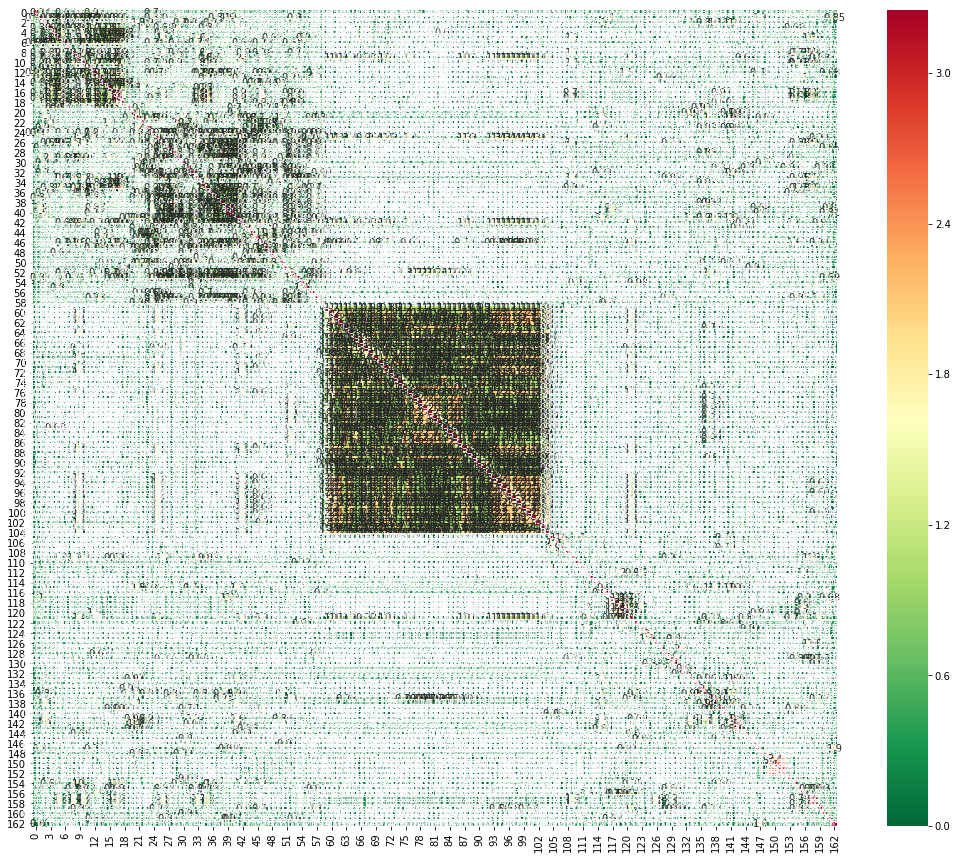

In [103]:
%%time
f, ax= plt.subplots(figsize = (18, 15))
# sns.heatmap(correlation_mat, cmap='RdYlGn_r', annot=True, ax=ax)
sns.heatmap(overall_indice, cmap='RdYlGn_r', annot=True, ax=ax)

### Appendix

* Check the first string in VoucherName (made as location according to the function "voucher_name_split") and MerchantName

In [ ]:
def doublecheck(input):
    if input.location == input.MerchantName:
        return 0
    elif input.location in input.MerchantName:
        return 0
    elif input.MerchantName in input.location:
        return 0
    else:
        return 1
    
sum([doublecheck(details.iloc[idx]) for idx in range(details.shape[0])])

* So there are 55 mismatch of location and merchant name. For example,  

In [ ]:
print details.location.iloc[84]
print details.MerchantName.iloc[84]

### Currently under-doubt Features

* For very precise result, we can use remarks to adjust (i.e., + or -) the value to the reward.

In [ ]:
details.Remarks.unique()

* Can i know that 'length' stand for what

In [ ]:
details.Length.unique()

### Other Features

* Feature meaning

In [ ]:
title

In [ ]:
details.iloc[0].voucher